# Introduction

This is a 4 layers Convolutional Neural Network for handwritten digit recognition on MNIST dataset.
I achieved <b>99.66%</b> of validation accuracy with pure CNN model with 1h45p training.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import itertools

# Data Preparation

### Load data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Data normalization & Reshape

In [3]:
X_train = X_train / 255
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test / 255
X_test = X_test.reshape(-1, 28, 28, 1)

In [4]:
print(X_train.min())
print(X_train.max())

0.0
1.0


### Label encoding

In [5]:
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

# CNN model

### Define the model

* The first is Convolutional layer: I choose 32 filters for the two first layers and 64 filters for the two last ones.
* The second is Pooling layer: I choose MaxPool2D & strides=(1,1) instead of strides=(2,2) or more. Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.
* Dropout is added on to reduce overfitting.
* Activation function is 'relu'.
* The Flatten layer is use to convert the final feature maps into a one single 1D vector. It combines all the found local features of the previous convolutional layers.
* In the end I used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, 
                 kernel_size=5, 
                 padding='same', 
                 input_shape=(28,28,1), 
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, 
                 kernel_size=5,  
                 padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, 
                 kernel_size=3,  
                 padding='same',  
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, 
                 kernel_size=3,  
                 padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

### Set of optimizer & annealer

* Once our layers are added to the model, we need to set up a score function, a loss function and an optimizer algorithm.
* We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".
* I choose Adam optimizer (with default values) because this optimizer works faster and provides better result.
* The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [7]:
model.compile(optimizer='Adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

* In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).
* The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.
* With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Data augmentation

Data augmentation is added on to prevent overfitting.

In [9]:
train_datagen = ImageDataGenerator()

### Fit the model 

In [10]:
start = time.time()
model.fit(train_datagen.flow(X_train, y_cat_train, batch_size=64), epochs=100, 
                             validation_data=(X_test, y_cat_test), callbacks=[learning_rate_reduction])
total_time = round(time.time() - start, 2)

Epoch 1/100
938/938 [==============================] - 75s 71ms/step - loss: 0.2827 - accuracy: 0.9153 - val_loss: 0.0476 - val_accuracy: 0.9855
Epoch 2/100
938/938 [==============================] - 62s 66ms/step - loss: 0.1131 - accuracy: 0.9690 - val_loss: 0.0445 - val_accuracy: 0.9855
Epoch 3/100
938/938 [==============================] - 62s 66ms/step - loss: 0.0872 - accuracy: 0.9766 - val_loss: 0.0381 - val_accuracy: 0.9881
Epoch 4/100
938/938 [==============================] - 62s 67ms/step - loss: 0.0713 - accuracy: 0.9805 - val_loss: 0.0381 - val_accuracy: 0.9905
Epoch 5/100
938/938 [==============================] - 62s 67ms/step - loss: 0.0641 - accuracy: 0.9822 - val_loss: 0.0216 - val_accuracy: 0.9934
Epoch 6/100
938/938 [==============================] - 62s 67ms/step - loss: 0.0559 - accuracy: 0.9850 - val_loss: 0.0294 - val_accuracy: 0.9911
Epoch 7/100
938/938 [==============================] - 62s 67ms/step - loss: 0.0493 - accuracy: 0.9861 - val_loss: 0.0369 - val_ac

In [11]:
print('Train accuracy:', max(model.history.history['accuracy']))
print('Validation accuracy:', max(model.history.history['val_accuracy']))
print('Training time:', total_time)

Train accuracy: 0.9989166855812073
Validation accuracy: 0.9965999722480774
Training time: 6278.82


# Evaluate the model

### Training and Validation curves

In [12]:
history_df = pd.DataFrame(model.history.history)
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.282727,0.915283,0.047612,0.9855,0.00100
1,0.113107,0.969033,0.044501,0.9855,0.00100
2,0.087198,0.976617,0.038077,0.9881,0.00100
3,0.071346,0.980533,0.038060,0.9905,0.00100
4,0.064061,0.982150,0.021610,0.9934,0.00100
...,...,...,...,...,...
95,0.004132,0.998467,0.017921,0.9963,0.00001
96,0.004381,0.998600,0.017787,0.9963,0.00001
97,0.003867,0.998700,0.017969,0.9962,0.00001
98,0.003988,0.998533,0.017931,0.9963,0.00001


<AxesSubplot:>

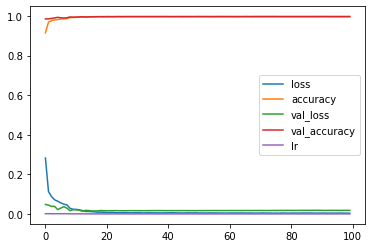

In [13]:
history_df.plot()

The validation accuracy and the training accuracy keep getting better almost every time during the training. That means that our model does not overfit the training set.

### Confusion matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

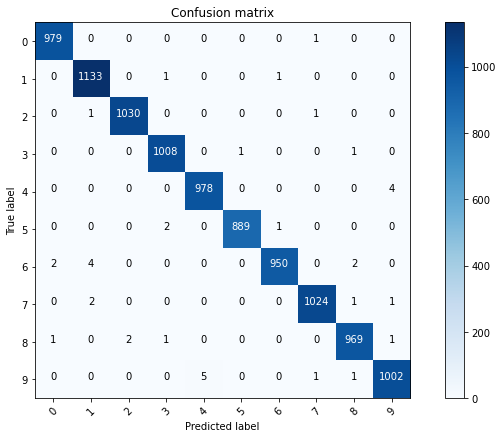

In [15]:
y_predict = model.predict(X_test)
y_pred_classes = np.argmax(y_predict, axis = 1) 
y_true = np.argmax(y_cat_test, axis = 1) 

plt.figure(figsize=(10,6))
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

# Predit values

In [16]:
def show(x):
  image = X_test[x]
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()
  print("Predict:", np.argmax(y_predict[x]))
  print("Answer:", y_test[x])

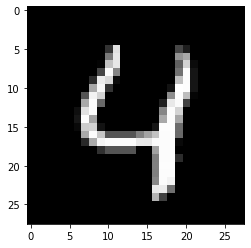

Predict: 4
Answer: 4


In [17]:
show(4)

# DONE